In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
import pandas as pd
import numpy as np
import gzip
import json
import math
from datetime import datetime
from IPython.display import display
%matplotlib inline

In [2]:
from helper.manage_orderbooks_v2 import extract_orderbooks_for_one_currencypair, load_orderbook_snapshot
from helper.orderbook_container import OrderbookContainer
from helper.orderbook_trader import OrderbookTradingSimulator

In [3]:
filename = '3000orderbooks'
data = load_orderbook_snapshot(filename, last_line=200)

100%|██████████| 200/200 [00:05<00:00, 39.88it/s]

Loaded 200 orderbooks from file '3000orderbooks'.


#### Test Orderbook plot, print and compare_with

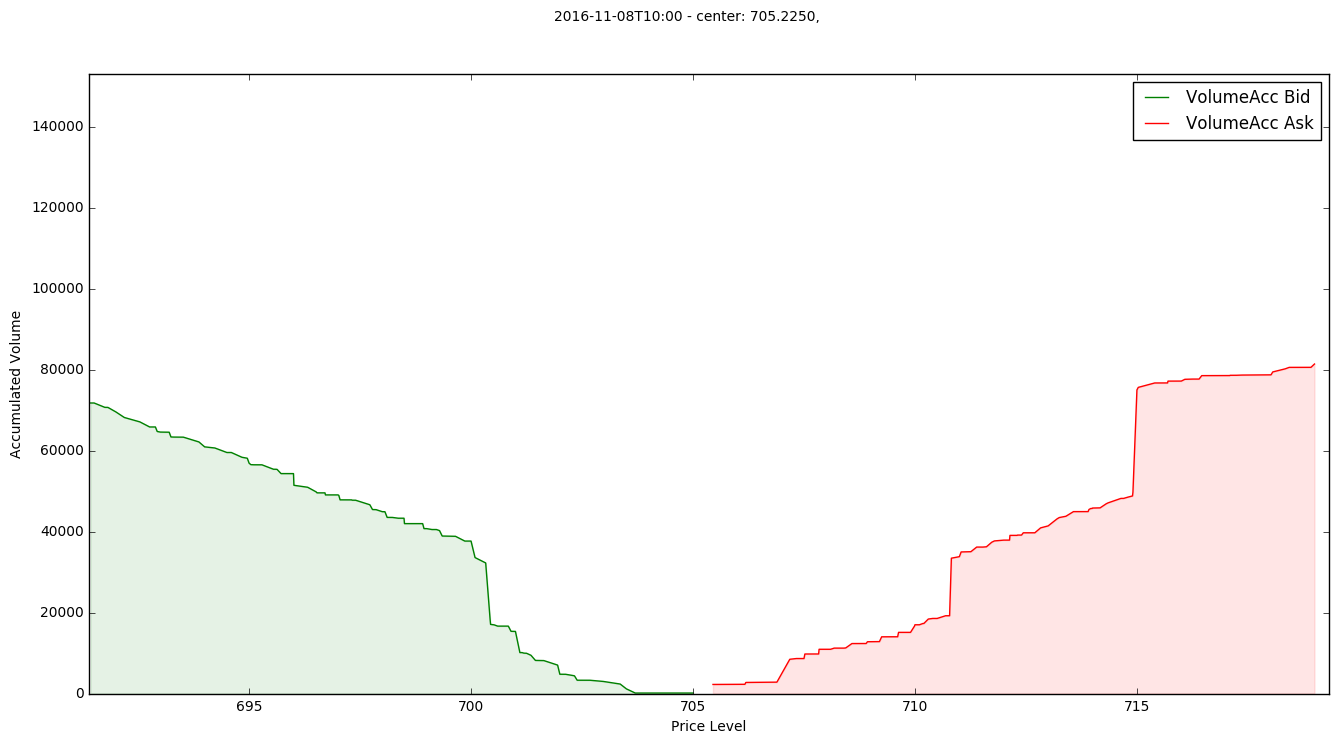

OrderbookContainer from 2016-11-08T10:00
  499 bids (best: 705.0)
  407 asks (best: 705.45)
  kind: 'orderbook'
OrderbookContainer from 2016-11-08T10:01
  499 bids (best: 703.8)
  406 asks (best: 705.45)
  kind: 'orderbook'

Compare two orderbooks:


,Amount,Volume,VolumeAcc,norm_Price,Type
685.11,0.473604,324.471015,108526.174016,0.971477,bid
678.34,0.511551,347.005553,142564.324900,0.961877,bid
674.59,0.546871,368.913775,150950.334759,0.956560,bid
705.45,-1.876972,2237.815171,2237.815171,1.000319,ask
706.89,0.105160,74.336899,2805.184977,1.002361,ask
707.18,6.456261,5649.346841,8454.531818,1.002772,ask


OrderbookContainer from 2016-11-08T10:01
  12 bids (best: 674.59)
  15 asks (best: 705.45)
  kind: 'diff'


In [55]:
orderbook = data[0]
orderbook.plot(range_factor=1.02)  # outfile='sample.pdf')
print(orderbook)
orderbook2 = data[1]
print(orderbook2)

print("\nCompare two orderbooks:")
diff = orderbook.compare_with(other=orderbook2)

display(diff.head())
print(diff)

#### Test get_current_price()

In [40]:
vol = 4

for factor in [0.25, 0.5, 0.75, 1.]:
    res = orderbook.get_current_price(vol*factor)
    print("Current MarketOrderPrice for {:1.4f} shares: {}".format(vol*factor, res))

Current MarketOrderPrice for 1.0000 shares: (705.45000000000005, 705.45000000000005)
Current MarketOrderPrice for 2.0000 shares: (1410.9000000000001, 705.45000000000005)
Current MarketOrderPrice for 3.0000 shares: (2116.3500000000004, 705.45000000000005)
Current MarketOrderPrice for 4.0000 shares: (2822.5093944685, 707.17999999999995)


#### Test orderbook.head and tail

In [11]:
display(orderbook.head(2))
display(orderbook.tail(2))

,Amount,Type,Volume,VolumeAcc,norm_Price
703.700000,0.001250,bid,0.879625,112.433157,0.997838
705.000000,0.158232,bid,111.553532,111.553532,0.999681
705.224976,NaN,center,NaN,NaN,NaN
705.450000,3.172181,ask,2237.815171,2237.815171,1.000319
706.170000,0.052838,ask,37.312497,2275.127669,1.001340


,Amount,Type,Volume,VolumeAcc,norm_Price
614.000000,1.838163,bid,1128.632254,326770.989935,0.870644
614.320000,0.034763,bid,21.355643,325642.357681,0.871098
705.224976,NaN,center,NaN,NaN,NaN
810.000000,0.286798,ask,232.306137,292461.937892,1.148570
811.000000,0.000100,ask,0.081100,292462.018992,1.149988


#### Test parameter limit

In [53]:
P = 10
vol=20
T = 12
ots = OrderbookTradingSimulator(volume=vol, tradingperiods=T, decisionfrequency=P)

for e in tqdm(range(T)):
    res = ots.trade(orderbooks=data[P*e:P*(e+1)], limit=707, verbose=True)

display(ots.history)
display(res)

 25%|██▌       | 3/12 [00:00<00:00,  9.85it/s]

t=10: Traded 15.2370/20.0000 shares for -10759.8754664, 4.7630 shares left


100%|██████████| 12/12 [00:00<00:00, 25.06it/s]

t=40: Traded 4.6358/4.7630 shares for -3271.51483807, 0.1273 shares left
No shares left at t=6 (self.t=47), Done!
t=47: Traded 0.1273/0.1273 shares for -89.886612311, 0.0000 shares left


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T10:00,705.45,705.00,705.224976,707,0.45,10,20.000000,706.16874,-10759.875466,10.951410,0.71874,False,706.89,705.000000,15.236975
2016-11-08T10:10,707.15,704.11,705.628909,707,3.04,10,4.763025,0.00000,0.000000,0.000000,0.00000,False,0.00,inf,0.000000
2016-11-08T10:20,707.10,705.00,706.049479,707,2.10,10,4.763025,0.00000,0.000000,0.000000,0.00000,False,0.00,inf,0.000000
2016-11-08T10:30,707.10,704.44,705.769165,707,2.66,10,4.763025,705.71401,-3271.514838,1.223900,0.26401,False,707.00,703.800000,4.635752
2016-11-08T10:40,706.19,703.78,704.984313,707,2.41,10,0.127273,706.24833,-89.886612,0.101606,0.79833,False,706.83,703.630000,0.127273


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T11:51,None,None,None,707,None,10,0.0,0,0,0,0,False,0,inf,0


#### Test parameter aggression_factor

In [52]:
P   =   10
vol = 20
T   =  12
ots = OrderbookTradingSimulator(volume=vol, tradingperiods=T, decisionfrequency=P)

for e in tqdm(range(T)):
    res = ots.trade(orderbooks=data[P*e:P*(e+1)], agression_factor=0.1, verbose=True)

display(ots.history)
display(res)

 25%|██▌       | 3/12 [00:00<00:00,  9.77it/s]

t=10: Traded 6.8581/20.0000 shares for -4838.05904847, 13.1419 shares left
t=20: Traded 0.7440/13.1419 shares for -525.3987904, 12.3979 shares left
t=30: Traded 0.0260/12.3979 shares for -18.415380063, 12.3719 shares left


100%|██████████| 12/12 [00:00<00:00, 34.80it/s]

No shares left at t=2 (self.t=33), Done!
t=33: Traded 12.3719/12.3719 shares for -8748.88519647, 0.0000 shares left


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded,LIMIT_MAX
2016-11-08T10:00,705.45,705.00,705.224976,705.868,0.45,10,20.000000,705.45000,-4838.059048,-0.000005,0.00000,False,705.45,705.00,6.858118,709.63
2016-11-08T10:10,706.17,704.11,705.139498,706.411,2.06,10,13.141882,706.20213,-525.398790,0.559567,0.75213,False,706.41,706.17,0.743978,708.58
2016-11-08T10:20,707.10,705.00,706.049479,707.123,2.10,10,12.397904,707.10000,-18.415380,0.042972,1.65000,False,707.10,707.10,0.026044,707.33
2016-11-08T10:30,707.16,704.44,705.799126,707.227,2.72,10,12.371861,707.16000,-8748.885196,21.155882,1.71000,False,707.16,707.16,12.371861,707.83


,ASK,BID,CENTER,LIMIT,SPREAD,T,VOLUME,avg,cashflow,cost,cost_avg,forced,high,low,volume_traded
2016-11-08T11:51,None,None,None,None,None,10,0.0,0,0,0,0,False,0,inf,0


### 